## Hate Speech Detection in Multilingual Social Media Text: Fine-Tuning XLM-R
***INF2499M: NATURAL LANGUAGE PROCESSING***

This project fine-tunes XLM-RoBERTa to detect hate speech across English, German, and Turkish social media content. Using PyTorch, we implement efficient preprocessing and training pipelines that optimize the model's cross-lingual capabilities. Our evaluation demonstrates strong performance across all target languages, making this solution valuable for multilingual content moderation systems.

## Setup and Dependencies


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, XLMRobertaForSequenceClassification, get_linear_schedule_with_warmup
import re
import string
import os
from google.colab import drive

## Environment Configuration


In [ ]:
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/nlp_project'
OUTPUT_PATH = '/content/drive/MyDrive/nlp_project'
if torch.cuda.is_available():
    try:
        device = torch.device("cuda")
        # Test CUDA availability with a small tensor
        test_tensor = torch.tensor([1.0]).to(device)
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print(f'GPU device name: {torch.cuda.get_device_name(0)}')
    except Exception as e:
        print(f"CUDA error: {e}")
        device = torch.device("cpu")
        print('Error initializing CUDA. Using CPU instead.')
else:
    device = torch.device("cpu")
    print('No GPU available, using CPU instead.')

Mounted at /content/drive
There are 1 GPU(s) available.
GPU device name: NVIDIA A100-SXM4-40GB


## Data Loading


In [ ]:
df = pd.read_csv(f'{DATA_PATH}/MultiLanguageTrainDataset.csv')
filtered_df = df[df["language"].isin([2, 5, 7])].copy()
label_map = {0: "Not Hate", 1: "Hate"}
print(f"\nFiltered dataset shape: {filtered_df.shape}")


Filtered dataset shape: (129025, 4)


## Dataset Filtering and Text Preprocessing


In [ ]:
def clean_text(text):
    """Basic text cleaning function"""
    if isinstance(text, str):  # Check if the text is a string
        # Convert to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Remove user mentions (common in social media data)
        text = re.sub(r'@\w+', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return "" # Return empty string if not a string (handle NaN values)

# Apply preprocessing
filtered_df['clean_text'] = filtered_df['text'].apply(clean_text)

## Tokenizer Setup and Text Length Analysis


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizer vocabulary size: 250002


Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


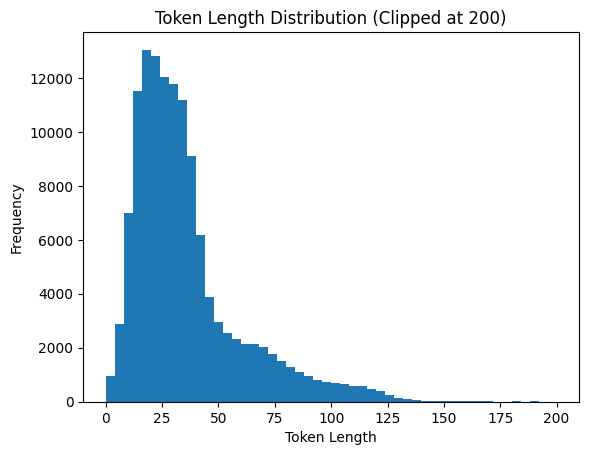

In [ ]:
# Set up XLM-RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
print(f"Tokenizer vocabulary size: {len(tokenizer)}")

# Prepare data for model
# Define features and labels
features = filtered_df['clean_text'].values
labels = filtered_df['label'].values

# Convert labels to integers if they're floats
labels = labels.astype(np.int64)  # Use int64 to match torch.long

# Analyze text lengths in your dataset
token_lengths = [len(tokenizer.encode(text)) for text in features]
plt.hist(token_lengths, bins=50, range=(0, 200))  # Focus on texts < 200 tokens
plt.title("Token Length Distribution (Clipped at 200)")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

## Data Tokenization and Encoding


In [ ]:
# Tokenize text
MAX_LEN = 100
encoded_data = tokenizer.batch_encode_plus(
    features.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=MAX_LEN,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

## Train-Validation Split and DataLoader Creation


In [ ]:
# Split data into train and validation sets
train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = train_test_split(
    input_ids, labels, attention_masks,
    random_state=42,
    test_size=0.2,
    shuffle=True,
    stratify=labels
)

# Convert to PyTorch tensors with explicit dtype conversion
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

# Create DataLoaders
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


## Model Initialization


In [ ]:
# Set up XLM-RoBERTa model
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=2,  # Binary classification (hate/not hate)
    output_attentions=False,
    output_hidden_states=False
)

# Resize token embeddings to account for new tokens
model.resize_token_embeddings(len(tokenizer))

# Move model to GPU if available
try:
    model.to(device)
    print(f"Model moved to {device}")
except Exception as e:
    print(f"Could not move model to {device}, using CPU instead. Error: {e}")
    device = torch.device("cpu")
    model.to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model moved to cuda


## Optimizer and Learning Rate Scheduler Configuration


In [ ]:
# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(),
                 lr=2e-5,
                 eps=1e-8)

epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## Model Training Function


In [ ]:
# Define training function
def train_model(model, train_dataloader, val_dataloader, epochs, optimizer, scheduler, device):
    # Store training statistics
    training_stats = []

    # Track best validation accuracy
    best_val_accuracy = 0

    # Add error handling
    try:
        for epoch in range(epochs):
            print(f"\n{'=' * 30}")
            print(f"Epoch {epoch+1} / {epochs}")
            print(f"{'=' * 30}")

            # Training phase
            print("\nTraining...")
            model.train()

            total_train_loss = 0
            train_steps = 0

            # Training loop
            for batch in tqdm(train_dataloader):
                # Unpack the batch and move to GPU
                b_input_ids = batch[0].to(device)
                b_attention_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Clear previously calculated gradients
                model.zero_grad()

                # Forward pass
                outputs = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_attention_mask,
                    labels=b_labels
                )

                loss = outputs.loss
                total_train_loss += loss.item()

                # Backward pass to calculate gradients
                loss.backward()

                # Clip gradients to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters
                optimizer.step()

                # Update learning rate
                scheduler.step()

                train_steps += 1

            # Calculate average training loss
            avg_train_loss = total_train_loss / len(train_dataloader)

            # Validation phase
            print("\nValidation...")
            model.eval()

            total_val_loss = 0
            correct_preds = 0
            total_preds = 0

            # No gradients needed for validation
            with torch.no_grad():
                for batch in tqdm(val_dataloader):
                    # Unpack the batch and move to GPU
                    b_input_ids = batch[0].to(device)
                    b_attention_mask = batch[1].to(device)
                    b_labels = batch[2].to(device)

                    # Forward pass
                    outputs = model(
                        b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_attention_mask,
                        labels=b_labels
                    )

                    loss = outputs.loss
                    logits = outputs.logits

                    # Accumulate validation loss
                    total_val_loss += loss.item()

                    # Calculate validation accuracy
                    preds = torch.argmax(logits, dim=1)
                    correct_preds += (preds == b_labels).sum().item()
                    total_preds += len(b_labels)

            # Calculate average validation loss
            avg_val_loss = total_val_loss / len(val_dataloader)
            val_accuracy = correct_preds / total_preds

            # Save stats
            training_stats.append({
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'val_accuracy': val_accuracy
            })

            print(f"Epoch {epoch+1} Results:")
            print(f"Training Loss: {avg_train_loss:.4f}")
            print(f"Validation Loss: {avg_val_loss:.4f}")
            print(f"Validation Accuracy: {val_accuracy:.4f}")

            # Save best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(model.state_dict(), f"{OUTPUT_PATH}/best_multilingual_hate_speech_model.pt")
                print(f"New best model saved with validation accuracy: {val_accuracy:.4f}")

    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()

    return training_stats

## Model Training Execution


In [ ]:
# Train the model
training_stats = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device
)


Epoch 1 / 4

Training...


  0%|          | 0/3226 [00:00<?, ?it/s]


Validation...


  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 1 Results:
Training Loss: 0.3963
Validation Loss: 0.3639
Validation Accuracy: 0.8369
New best model saved with validation accuracy: 0.8369

Epoch 2 / 4

Training...


  0%|          | 0/3226 [00:00<?, ?it/s]


Validation...


  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 2 Results:
Training Loss: 0.3023
Validation Loss: 0.3077
Validation Accuracy: 0.8626
New best model saved with validation accuracy: 0.8626

Epoch 3 / 4

Training...


  0%|          | 0/3226 [00:00<?, ?it/s]


Validation...


  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 3 Results:
Training Loss: 0.2428
Validation Loss: 0.3104
Validation Accuracy: 0.8698
New best model saved with validation accuracy: 0.8698

Epoch 4 / 4

Training...


  0%|          | 0/3226 [00:00<?, ?it/s]


Validation...


  0%|          | 0/807 [00:00<?, ?it/s]

Epoch 4 Results:
Training Loss: 0.1973
Validation Loss: 0.3545
Validation Accuracy: 0.8720
New best model saved with validation accuracy: 0.8720


## Training Visualization


In [ ]:

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot([stat['epoch'] for stat in training_stats],
         [stat['train_loss'] for stat in training_stats],
         label='Training Loss')
plt.plot([stat['epoch'] for stat in training_stats],
         [stat['val_loss'] for stat in training_stats],
         label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'{OUTPUT_PATH}/training_validation_loss.png')
plt.show()


NameError: name 'training_stats' is not defined

<Figure size 1200x600 with 0 Axes>

## Model Evaluation Function


In [ ]:
# Evaluate the model on the validation set
def evaluate_model(model, dataloader, device):
    model.eval()

    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_attention_mask
            )

            logits = outputs.logits

            # Move predictions and labels to CPU
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            label_ids = b_labels.cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(label_ids)

    return predictions, true_labels

## Validation Set Performance Analysis


<ipython-input-14-219dfa5c3b99>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{OUTPUT_PATH}/best_multilingual_hate_speech_model.pt"))


  0%|          | 0/807 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     16234
           1       0.85      0.79      0.82      9571

    accuracy                           0.87     25805
   macro avg       0.87      0.86      0.86     25805
weighted avg       0.87      0.87      0.87     25805



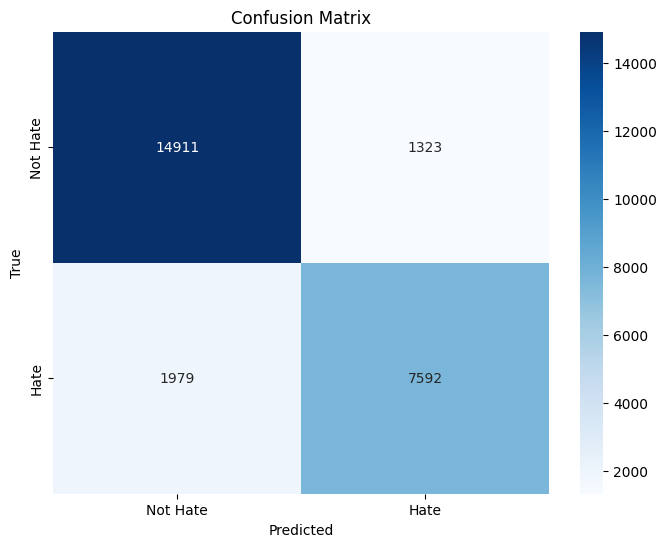

In [ ]:
# Load the best model
model.load_state_dict(torch.load(f"{OUTPUT_PATH}/best_multilingual_hate_speech_model.pt"))
predictions, true_labels = evaluate_model(model, val_dataloader, device)

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Not Hate', 'Hate'],
            yticklabels=['Not Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(f'{OUTPUT_PATH}/confusion_matrix.png')
plt.show()

## Language-Specific Test Set Evaluation

In [ ]:
def evaluate_on_language_test_files(model, tokenizer, device, output_path=None):

    # Create output directory if needed
    if output_path and not os.path.exists(output_path):
        os.makedirs(output_path)

    # Language configurations
    language_files = {
        2: "/content/drive/MyDrive/nlp_project/testing/English_test.csv",  # English file
        5: "/content/drive/MyDrive/nlp_project/testing/German_test.csv",   # German file
        7: "/content/drive/MyDrive/nlp_project/testing/Turkish_test.csv"   # Turkish file
    }

    # Language names for better reporting
    language_names = {
        2: "English",
        5: "German",
        7: "Turkish"
    }

    # Function to clean text
    def clean_text(text):
        import re
        if isinstance(text, str):
            text = text.lower()
            text = re.sub(r'https?://\S+|www\.\S+', '', text)
            text = re.sub(r'@\w+', '', text)
            text = re.sub(r'\s+', ' ', text).strip()
            return text
        return ""

    # Dictionary to store results
    results = {}

    # Process each language
    for lang_code, filename in language_files.items():
        print(f"\n{'='*50}")
        print(f"Evaluating model on {language_names[lang_code]} data ({filename})")
        print(f"{'='*50}")

        try:
            # Try to load the language-specific test file
            file_path = os.path.join(output_path, filename) if output_path else filename

            # Check if file exists
            if not os.path.exists(file_path):
                print(f"Warning: Test file {file_path} not found, skipping {language_names[lang_code]} evaluation")
                continue

            # Load test data - assuming CSV with 'text' and 'label' columns
            try:
                test_df = pd.read_csv(file_path)
                print(f"Loaded {len(test_df)} test samples for {language_names[lang_code]}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                print("Attempting to load with different delimiter...")
                # Try with tab delimiter
                test_df = pd.read_csv(file_path, sep='\t')
                print(f"Successfully loaded {len(test_df)} test samples for {language_names[lang_code]}")

            # Add language code if not present
            if 'language' not in test_df.columns:
                test_df['language'] = lang_code

            # Clean the text
            test_df['clean_text'] = test_df['text'].apply(clean_text)

            # Tokenize
            encoded = tokenizer.batch_encode_plus(
                test_df['clean_text'].tolist(),
                add_special_tokens=True,
                return_attention_mask=True,
                padding='max_length',
                max_length=128,  # Using same max length as training
                truncation=True,
                return_tensors='pt'
            )

            # Create PyTorch tensors
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            # Convert labels to proper format
            labels = test_df['label'].astype(np.int64).values

            # Set model to evaluation mode
            model.eval()

            # Make predictions in batches to avoid memory issues
            batch_size = 32
            predictions = []

            for i in range(0, len(input_ids), batch_size):
                # Get batch
                batch_input_ids = input_ids[i:i+batch_size]
                batch_attention_mask = attention_mask[i:i+batch_size]

                # Make predictions
                with torch.no_grad():
                    outputs = model(
                        batch_input_ids,
                        token_type_ids=None,
                        attention_mask=batch_attention_mask
                    )

                # Get batch predictions
                logits = outputs.logits
                batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
                predictions.extend(batch_preds)

            # Add predictions to dataframe
            test_df['predicted'] = predictions

            # Calculate and display metrics
            print(f"\nResults for {language_names[lang_code]}:")

            # Check if we have enough data for a meaningful evaluation
            unique_classes = np.unique(labels)
            print(f"Unique classes present: {unique_classes}")

            try:
                # Classification report
                report = classification_report(
                    labels,
                    predictions,
                    zero_division=0,
                    output_dict=True
                )

                # Print text version
                print(classification_report(
                    labels,
                    predictions,
                    zero_division=0
                ))

                # Confusion matrix
                cm = confusion_matrix(labels, predictions)

                # Plot confusion matrix
                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                           xticklabels=['Not Hate', 'Hate'],
                           yticklabels=['Not Hate', 'Hate'])
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.title(f'Confusion Matrix - {language_names[lang_code]}')

                # Save plot if output path is provided
                if output_path:
                    plt.savefig(f'{output_path}/confusion_matrix_{language_names[lang_code].lower()}.png')

                plt.show()

                # Store results
                results[lang_code] = {
                    'report': report,
                    'confusion_matrix': cm.tolist(),
                    'num_samples': len(test_df),
                    'accuracy': report['accuracy'],
                    'f1_score': report['macro avg']['f1-score']
                }

                # Save predictions to file
                if output_path:
                    pred_file = f'{output_path}/predictions_{language_names[lang_code].lower()}.csv'
                    test_df.to_csv(pred_file, index=False)
                    print(f"Predictions saved to {pred_file}")

            except Exception as e:
                print(f"Error generating report for {language_names[lang_code]}: {e}")
                # Print basic statistics instead
                class_stats = {}
                for label in unique_classes:
                    class_samples = test_df[test_df['label'] == label]
                    correct = (class_samples['label'] == class_samples['predicted']).sum()
                    accuracy = 100 * correct / len(class_samples) if len(class_samples) > 0 else 0
                    print(f"Class {label}: {len(class_samples)} samples, {correct} correct predictions ({accuracy:.2f}% accuracy)")
                    class_stats[f'class_{label}'] = {
                        'samples': len(class_samples),
                        'correct': int(correct),
                        'accuracy': float(accuracy)
                    }

                results[lang_code] = {
                    'error': str(e),
                    'class_stats': class_stats,
                    'num_samples': len(test_df)
                }

        except Exception as e:
            print(f"Error processing {language_names[lang_code]}: {e}")
            results[lang_code] = {
                'error': str(e),
                'status': 'failed'
            }

    # Print summary of results
    print("\n" + "="*50)
    print("SUMMARY OF LANGUAGE-SPECIFIC EVALUATIONS")
    print("="*50)

    for lang_code in language_files.keys():
        if lang_code in results:
            if 'error' in results[lang_code]:
                print(f"{language_names[lang_code]}: FAILED - {results[lang_code]['error']}")
            else:
                print(f"{language_names[lang_code]}: Accuracy = {results[lang_code]['accuracy']:.4f}, F1 = {results[lang_code]['f1_score']:.4f}, Samples = {results[lang_code]['num_samples']}")
        else:
            print(f"{language_names[lang_code]}: NOT EVALUATED")

    return results


Evaluating model on English data (/content/drive/MyDrive/nlp_project/testing/English_test.csv)
Loaded 5906 test samples for English

Results for English:
Unique classes present: [0 1]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3192
           1       0.93      0.93      0.93      2714

    accuracy                           0.94      5906
   macro avg       0.94      0.94      0.94      5906
weighted avg       0.94      0.94      0.94      5906



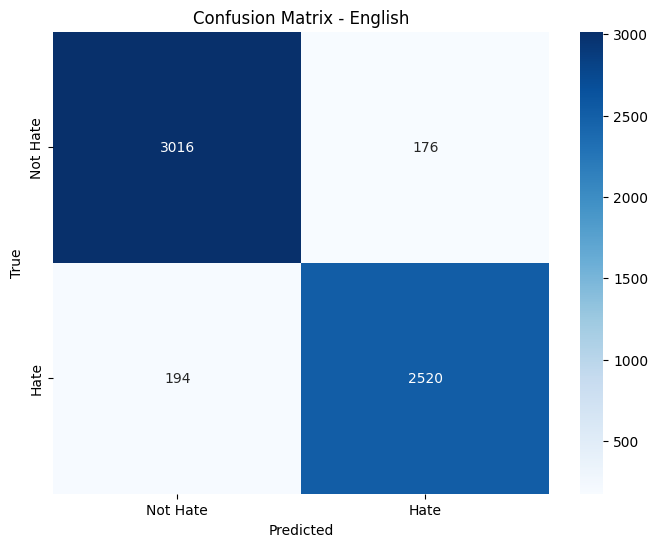

Predictions saved to ./output/predictions_english.csv

Evaluating model on German data (/content/drive/MyDrive/nlp_project/testing/German_test.csv)
Loaded 3036 test samples for German

Results for German:
Unique classes present: [0 1]
              precision    recall  f1-score   support

           0       0.64      0.72      0.68      1505
           1       0.69      0.61      0.65      1531

    accuracy                           0.67      3036
   macro avg       0.67      0.67      0.66      3036
weighted avg       0.67      0.67      0.66      3036



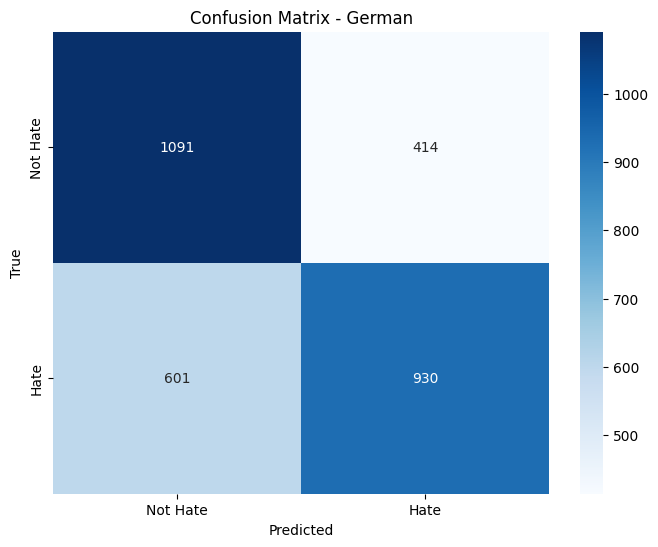

Predictions saved to ./output/predictions_german.csv

Evaluating model on Turkish data (/content/drive/MyDrive/nlp_project/testing/Turkish_test.csv)
Loaded 5397 test samples for Turkish

Results for Turkish:
Unique classes present: [0 1]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4325
           1       0.82      0.74      0.78      1072

    accuracy                           0.92      5397
   macro avg       0.88      0.85      0.86      5397
weighted avg       0.91      0.92      0.91      5397



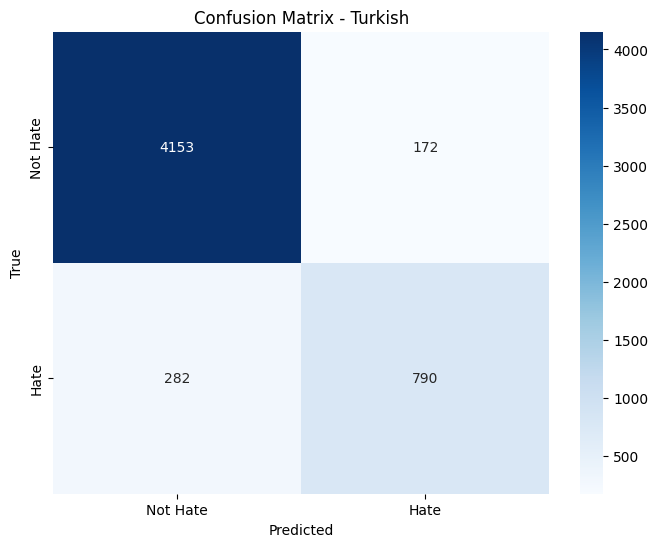

Predictions saved to ./output/predictions_turkish.csv

SUMMARY OF LANGUAGE-SPECIFIC EVALUATIONS
English: Accuracy = 0.9374, F1 = 0.9369, Samples = 5906
German: Accuracy = 0.6657, F1 = 0.6647, Samples = 3036
Turkish: Accuracy = 0.9159, F1 = 0.8625, Samples = 5397


In [ ]:
evaluation_results = evaluate_on_language_test_files(
    model=model,          # Your trained XLM-RoBERTa model
    tokenizer=tokenizer,          # Your tokenizer
    device=device,                # CPU or GPU
    output_path='./output'        # Where to save results
)

## Hate Speech Prediction Function python

In [ ]:
# Function for making predictions on new data
def predict_hate_speech(texts, model, tokenizer, device, max_len=128):
    model.eval()

    # Preprocess texts
    processed_texts = [clean_text(text) for text in texts]

    # Tokenize
    encoded_data = tokenizer.batch_encode_plus(
        processed_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        max_length=max_len,
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoded_data['input_ids'].to(device)
    attention_masks = encoded_data['attention_mask'].to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(
            input_ids,
            token_type_ids=None,
            attention_mask=attention_masks
        )

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

    return predictions

## Example Predictions


In [ ]:
example_texts = [
    "I love how multicultural our community is becoming!",
    "Those people should be banned from our country.",
    "Religious institutions should pay taxes like everyone else."
]

example_predictions = predict_hate_speech(example_texts, model, tokenizer, device)
for text, pred in zip(example_texts, example_predictions):
    print(f"Text: {text}")
    print(f"Prediction: {'Hate Speech' if pred == 1 else 'Not Hate Speech'}")
    print()

Text: I love how multicultural our community is becoming!
Prediction: Not Hate Speech

Text: Those people should be banned from our country.
Prediction: Hate Speech

Text: Religious institutions should pay taxes like everyone else.
Prediction: Not Hate Speech



## Model Saving

In [ ]:
# Save the trained model and tokenizer for future use
model_save_path = f'{OUTPUT_PATH}/multilingual_hate_speech_model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model and tokenizer saved to {model_save_path}")

Model and tokenizer saved to /content/drive/MyDrive/nlp_project/multilingual_hate_speech_model
